In [85]:
import pandas as pd

In [86]:
# Load data
df = pd.read_csv('crime_data.csv')

In [87]:
# Inspect data: Checking types, missing values, etc.
print(df.head()) # First 5 rows
print(df.info()) # Data types, non-null counts
print(df.describe()) # Stats for numerics

   CASE_NUMBER                    DATE  TIME  CODE  \
0     14174782  2014/08/17 23:00:00+00   NaN   510   
1     14174803  2014/08/18 03:24:00+00   NaN  1400   
2     14174804  2014/08/18 03:24:00+00   NaN   691   
3     14174813  2014/08/18 03:37:00+00   NaN   600   
4     14174817  2014/08/18 03:41:00+00   NaN   700   

                              INCIDENT_TYPE    INCIDENT  POLICE_GRID_NUMBER  \
0  Burglary, Forced Entry, Night, Residence    Burglary               115.0   
1               Criminal Damage to Property   Vandalism               128.0   
2              Theft, All Other, Under $500       Theft               107.0   
3                  Theft, Except Auto Theft       Theft               193.0   
4                       Motor Vehicle Theft  Auto Theft               132.0   

   NEIGHBORHOOD_NUMBER      NEIGHBORHOOD_NAME                BLOCK  \
0                    4     4 - Dayton's Bluff       101X EUCLID ST   
1                    8  8 - Summit/University        64X DAY

In [88]:
# Handle any missing data
print(df.isnull().sum()) # Count of missing data per column
df = df.dropna(subset=['DATE', 'INCIDENT_TYPE', 'NEIGHBORHOOD_NUMBER']) # Drop if key columns missing

CASE_NUMBER                   0
DATE                          0
TIME                     560025
CODE                          0
INCIDENT_TYPE                 0
INCIDENT                      2
POLICE_GRID_NUMBER           90
NEIGHBORHOOD_NUMBER           0
NEIGHBORHOOD_NAME             0
BLOCK                        22
CALL_DISPOSITION_CODE         0
CALL_DISPOSITION              0
Count_                   560025
ObjectId                      0
dtype: int64


In [89]:
# Parse dates/times to help with time-based analysis

df['DATETIME'] = pd.to_datetime(df['DATE'], errors='coerce')
df['YEAR'] = df['DATETIME'].dt.year
df['MONTH'] = df['DATETIME'].dt.month
df['HOUR'] = df['DATETIME'].dt.hour
df['DAY_OF_WEEK'] = df['DATETIME'].dt.day_name().astype('string')
df['SEASON'] = df['MONTH'].apply(lambda m: 'Winter' if m in [12,1,2] else 
                                 'Spring' if m in [3,4,5] else 
                                 'Summer' if m in [6,7,8] else 'Fall')

In [90]:
# Standardize categories to fix inconsistencies

df['INCIDENT_TYPE'] = df['INCIDENT_TYPE'].str.title().str.strip()

# Create mapping for incident type inconcsistencies
incident_map = {
    # Theft variants:
    'theft, except auto theft': 'Theft (Non-Auto)',
    'theft except auto theft': 'Theft (Non-Auto)',
    'theft except auto': 'Theft (Non-Auto)',
    'theft, all other, under $500': 'Theft (Other, Under $500)',
    'theft, shoplifting, under $500': 'Theft - Shoplifting (Under $500)',
    'theft, from auto': 'Theft From Auto',
    'theft from auto': 'Theft From Auto',
    'theft-from auto': 'Theft From Auto',
    'theft-from auto,under $500': 'Theft From Auto (Under $500)',
    'theft, from auto, under $500': 'Theft From Auto (Under $500)',
    'theft-auto accessories,under $500': 'Theft - Auto Accessories (Under $500)',
    'theft, auto accessories, under $500': 'Theft - Auto Accessories (Under $500)',
    'theft - auto accessories (under $500)': 'Theft - Auto Accessories (Under $500)',
    'theft, auto accessories, over $1000': 'Theft - Auto Accessories (Over $1000)',
    'theft-auto accessories,over $1000': 'Theft - Auto Accessories (Over $1000)',
    'theft, auto accessories, $501 to $1000': 'Theft - Auto Accessories ($501-$1000)',
    
    # Shoplifting
    'theft, shoplifting': 'Theft - Shoplifting',
    'theft-shoplifting': 'Theft - Shoplifting',
    'theft-shoplifting,under $500': 'Theft - Shoplifting (Under $500)',    
    
    # Theft other
    'theft, all other, over $1000': 'Theft (Other, Over $1000)',
    'theft-all other,under $500': 'Theft (Other, Under $500)',
    'theft, all other, $501 to $1000': 'Theft (Other, $501-$1000)',
    'theft-all other, over $1000': 'Theft (Other, Over $1000)',
    
    # Police visits / proactive
    'proactive police visit': 'Proactive Police Visit',
    'police visit-proactive police visit': 'Proactive Police Visit',
    'police visit proactive': 'Proactive Police Visit',
    
    # Criminal damage / vandalism
    'criminal damage to property': 'Criminal Damage to Property',
    'criminal damage to property (misdemeanor, under $250)': 'Criminal Damage (Misdemeanor < $250)',
    'criminal damage to property (misdemeanor under $500)': 'Criminal Damage (Misdemeanor < $500)',
    'criminal damage to property (felony over $1000)': 'Criminal Damage (Felony > $1000)',
    'criminal damage to property (felony, over $500)': 'Criminal Damage (Felony)',
    'criminal damage to property (gm $501 to $1000)': 'Criminal Damage (Felony)',
    
    # Auto theft variants
    'motor vehicle theft, automobile': 'Motor Vehicle Theft (Auto)',
    'auto theft-automobile': 'Motor Vehicle Theft (Auto)',
    'auto theft': 'Motor Vehicle Theft (Auto)',
    'motor vehicle theft': 'Motor Vehicle Theft (Auto)',
    
    # Narcotics / drugs
    'narcotics': 'Narcotics',
    'drugs-narcotics': 'Narcotics',
    
    # Assault / domestic
    'assault, domestic, opposite sex': 'Domestic Assault (Opposite Sex)',
    'aggravated assault, domestic': 'Aggravated Domestic Assault',
    'domestic-other assaults,all domestic opposite sex': 'Domestic Assault (Other)',
    
    # Community / engagement
    'community engagement event': 'Community Engagement Event',
    'community oriented/outreach event': 'Community Engagement Event',
    
    # Weapons
    'weapons, discharging a firearm in the city limits': 'Discharge of Firearm',
    'weapons-discharging a firearm in the city limits': 'Discharge of Firearm',
}

# Apply it (lower + strip first for matching)
df['INCIDENT_CLEAN'] = (
    df['INCIDENT_TYPE']
    .astype(str)
    .str.lower()
    .str.strip()
    .map(incident_map)
    .fillna(df['INCIDENT_TYPE'])
)

# Updating to title case for cleaner display
df['INCIDENT_CLEAN'] = df['INCIDENT_CLEAN'].str.title()


In [91]:
# Saving cleaned version
df.to_csv('cleaned_crime_data.csv', index=False)

In [92]:
# Including NO Proactive Police Visits df
df_no_proactive = df[
    df['INCIDENT_CLEAN'] != 'Proactive Police Visit'
].copy()

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

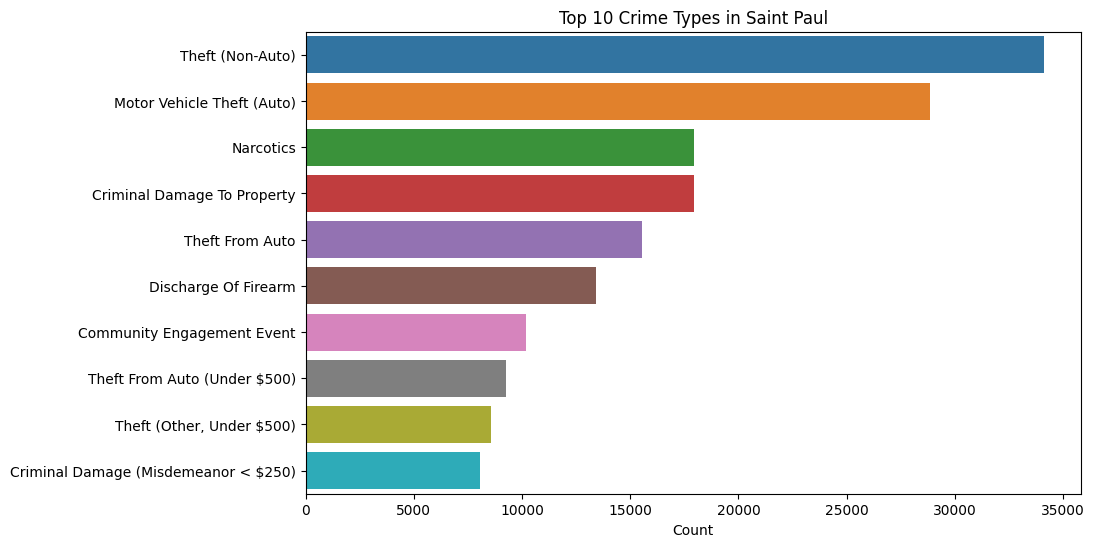

In [94]:
# Crime by type -- Identifying top issues
crime_counts = df_no_proactive['INCIDENT_CLEAN'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=crime_counts.values, y=crime_counts.index)
plt.title('Top 10 Crime Types in Saint Paul')
plt.xlabel('Count')
plt.savefig('top_crimes.png')
plt.show()

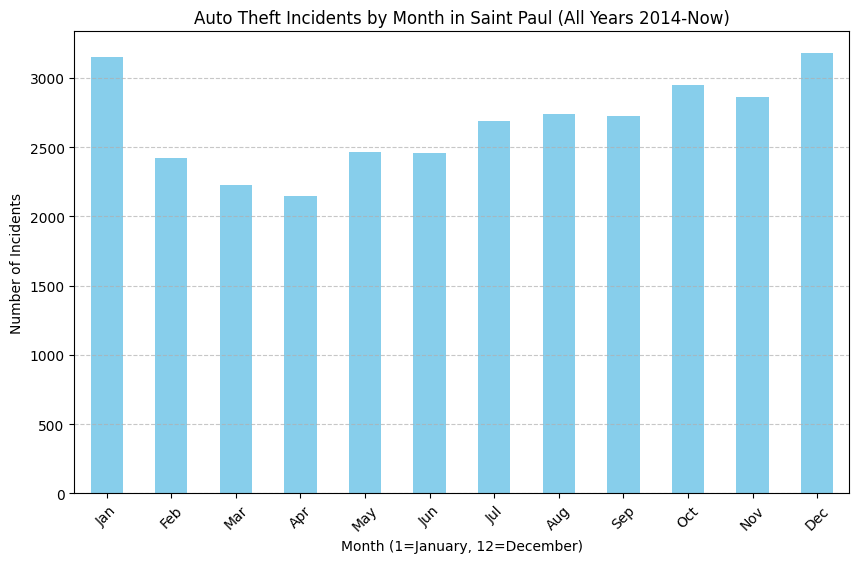

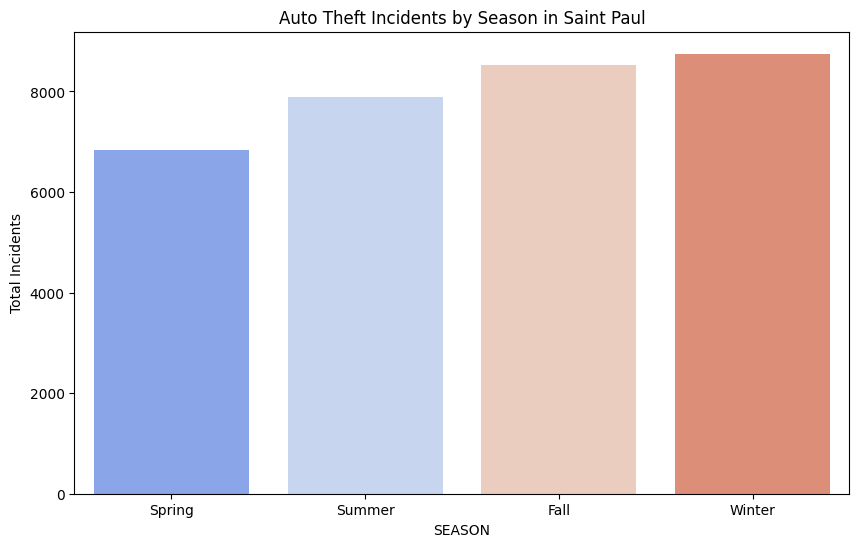

In [95]:
# Auto theft by month/season

# Filtering for just auto theft
auto_theft_df = df_no_proactive[
    df_no_proactive['INCIDENT_CLEAN'].str.contains('Auto|Vehicle Theft', case=False, na=False)
    &
    ~df_no_proactive['INCIDENT_CLEAN'].str.contains('Non-Auto|Theft from Auto|Accessories|Theft, From Auto|Theft-From Auto', case=False, na=False)]

# Monthly counts of auto theft
monthly_auto = auto_theft_df.groupby('MONTH').size()
plt.figure(figsize=(10,6))
monthly_auto.plot(kind='bar', color='skyblue')
plt.title('Auto Theft Incidents by Month in Saint Paul (All Years 2014-Now)')
plt.xlabel('Month (1=January, 12=December)')
plt.ylabel('Number of Incidents')
plt.xticks(range(12), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('auto_theft_by_month.png')
plt.show()

# Seasonal summary counts
seasonal_auto = auto_theft_df.groupby('SEASON').size().reindex(['Spring','Summer','Fall', 'Winter'])
plt.figure(figsize=(10,6))
sns.barplot(x=seasonal_auto.index, y=seasonal_auto.values, palette="coolwarm")
plt.title('Auto Theft Incidents by Season in Saint Paul')
plt.ylabel('Total Incidents')
plt.savefig('auto_theft_by_season.png')
plt.show()


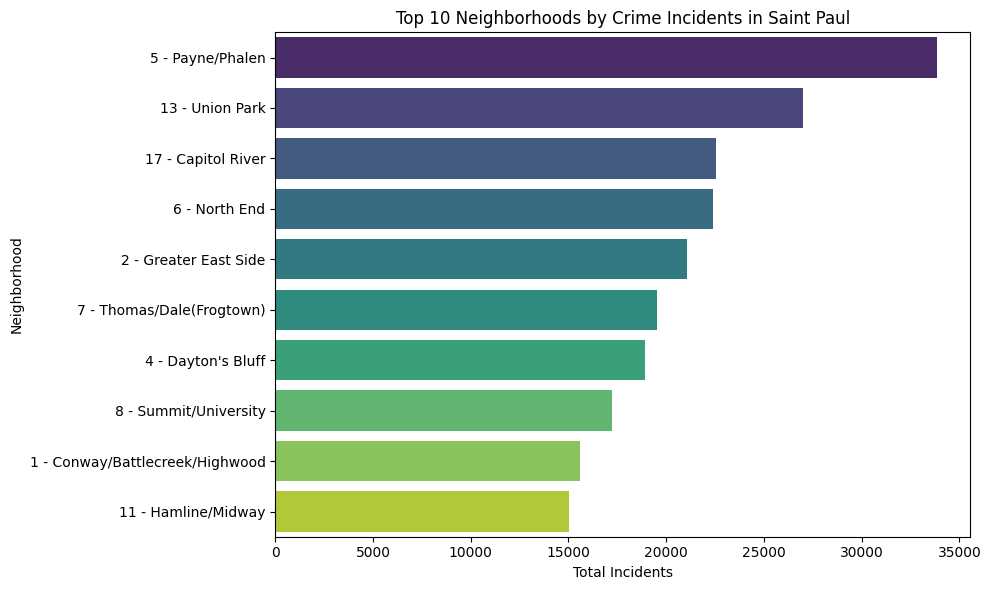

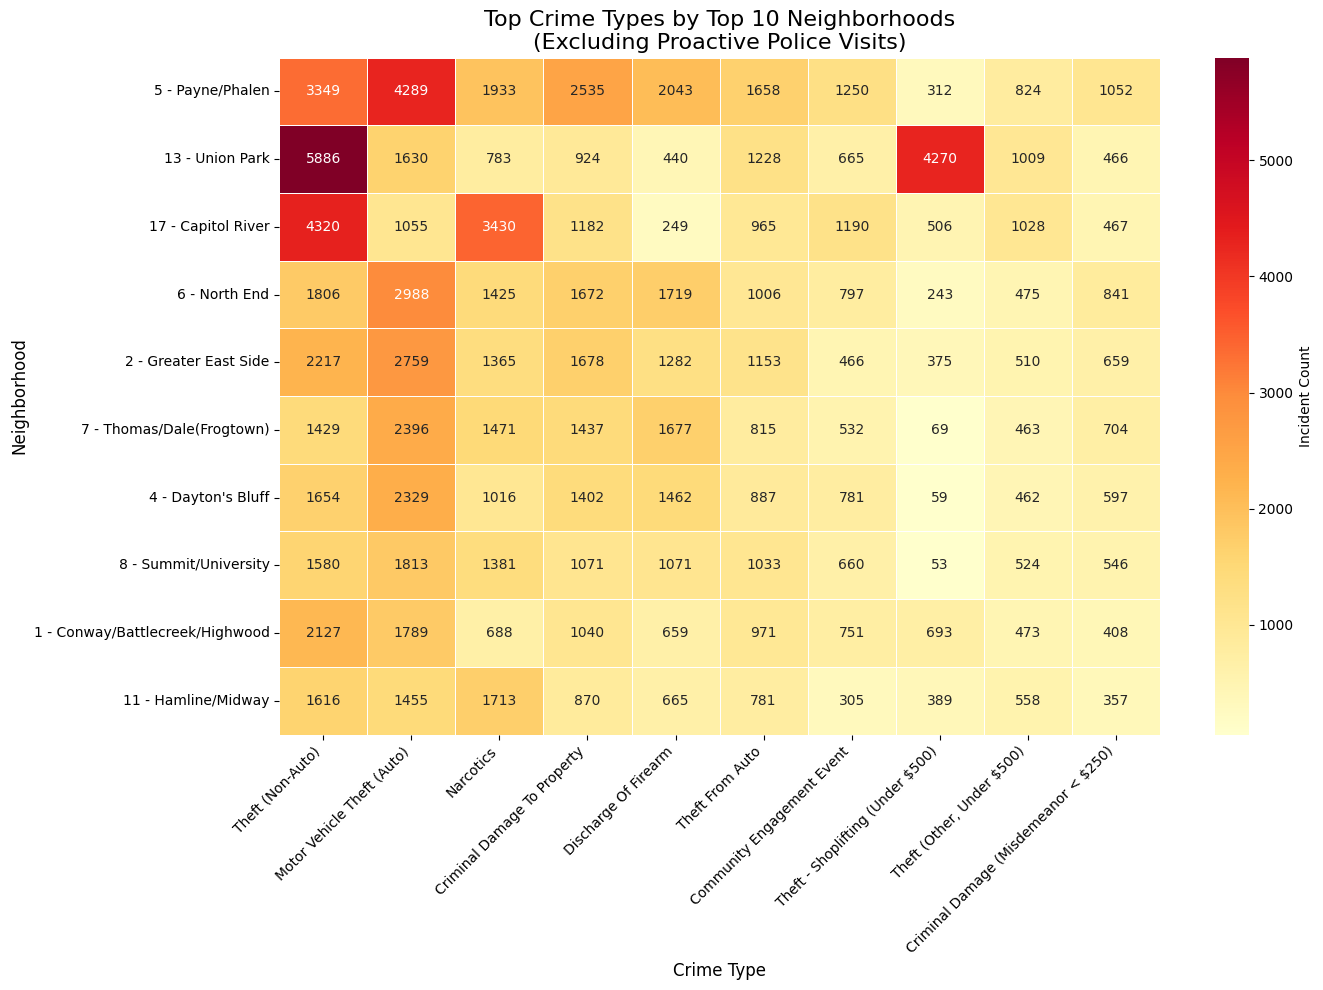

In [99]:
# Top 10 Neighborhoods by Total Crimes
neighborhood_counts = df_no_proactive['NEIGHBORHOOD_NAME'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=neighborhood_counts.values, y=neighborhood_counts.index, palette="viridis")
plt.title('Top 10 Neighborhoods by Crime Incidents in Saint Paul')
plt.xlabel('Total Incidents')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.savefig('neighborhood_crimes.png', dpi=300)
plt.show()

# Heatmap of top crime type per neighborhood
pivot_no_pro = df_no_proactive.pivot_table(
    index='NEIGHBORHOOD_NAME',
    columns='INCIDENT_CLEAN',
    aggfunc='size',
    fill_value=0
)
top_10_neigh = pivot_no_pro.sum(axis=1).nlargest(10).index
top_neigh_filtered = pivot_no_pro.loc[top_10_neigh]
top_crime_types = top_neigh_filtered.sum().nlargest(10).index
top_neigh_filtered = top_neigh_filtered[top_crime_types]

plt.figure(figsize=(14, 10))
sns.heatmap(
    top_neigh_filtered,
    cmap='YlOrRd',
    annot=True,
    fmt='d',
    linewidths=0.5,
    cbar_kws={'label': 'Incident Count'}
)
plt.title('Top Crime Types by Top 10 Neighborhoods\n(Excluding Proactive Police Visits)', fontsize=16)
plt.xlabel('Crime Type', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('neighborhood_heatmap_no_proactive.png', dpi=300, bbox_inches='tight')
plt.show()